# A/B Testing Case Study Using Simulated Data

## Project Overview
This case study performs A/B testing using real clickstream data to compare user engagement between two webpage versions — Control (`con`) and Experimental (`exp`). The primary metric is click-through rate (CTR), and the goal is to evaluate whether the new design significantly outperforms the original. WE will analyze whether the new variation improves user engagement.


In [33]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

## Step 1: Simulating Click Data for Control and Experimental Groups
**Objective:** To simulate realistic click behavior for two groups:
- Control group (`con`) with a lower click-through rate (CTR)
- Experimental group (`exp`) with a higher CTR

**Why Simulate?**
Simulating allows us to model controlled A/B experiments when real-world data is unavailable, and to test hypotheses and code logic under known conditions.

In [34]:
# Define sample size for each group
N_exp = 10000  # Experimental group
N_con = 10000  # Control group

# Generate binary click data using binomial distribution
click_exp = pd.Series(np.random.binomial(1, 0.5, size=N_exp))  # 50% CTR
click_con = pd.Series(np.random.binomial(1, 0.2, size=N_con))  # 20% CTR

# Create group identifiers
exp_id = pd.Series(np.repeat("exp", N_exp))
con_id = pd.Series(np.repeat("con", N_con))

# Create dataframes for each group
df_exp = pd.concat([click_exp, exp_id], axis=1)
df_con = pd.concat([click_con, con_id], axis=1)

# Rename columns
df_exp.columns = ["click", "group"]
df_con.columns = ["click", "group"]

# Combine both groups into a single A/B test dataset
df_ab_test = pd.concat([df_exp, df_con], axis=0).reset_index(drop=True)

# Preview the simulated dataset
df_ab_test.head()

,click,group
0,1,exp
1,0,exp
2,1,exp
3,0,exp
4,0,exp


In [35]:
df_ab_test.describe()

,click
count,20000.000000
mean,0.344400
std,0.475184
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


## Step 2: Visualizing Click Distribution

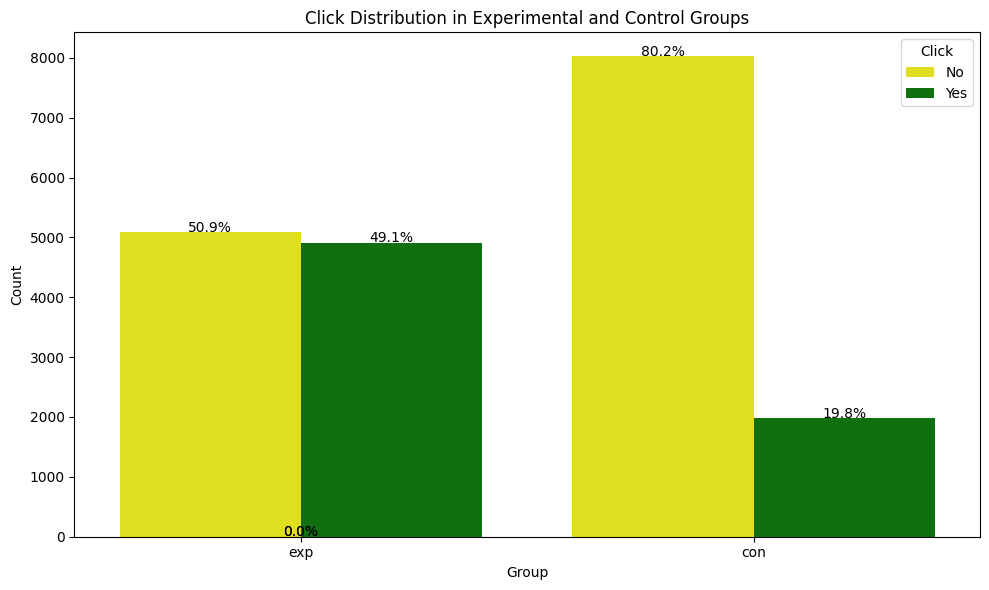

In [36]:
# Plot the click distribution
palette = {0: 'yellow', 1: 'green'}

plt.figure(figsize=(10, 6))
ax = sns.countplot(x='group', hue='click', data=df_ab_test, palette=palette)
plt.title('Click Distribution in Experimental and Control Groups')
plt.xlabel('Group')
plt.ylabel('Count')
plt.legend(title='Click', labels=['No', 'Yes'])

# Annotate bars with percentage values
group_counts = df_ab_test.groupby('group').size()

for p in ax.patches:
    height = p.get_height()
    group = 'exp' if p.get_x() < 0.5 else 'con'
    total = group_counts.loc[group]
    percentage = 100 * height / total
    ax.text(p.get_x() + p.get_width() / 2., height + 5, f'{percentage:.1f}%', 
            ha="center", color='black', fontsize=10)

plt.tight_layout()
plt.show()

**Interpretation:** The experimental group had a significantly higher click-through rate than the control group. This suggests that the new version (experimental condition) improved user engagement and may be more effective.

## Step 3: Total clicks

In [37]:
# Calculate the total number of clicks in each group
X_con = df_ab_test.groupby("group")["click"].sum().loc["con"]
X_exp = df_ab_test.groupby("group")["click"].sum().loc["exp"]

# Print group-wise click totals
print(df_ab_test.groupby("group")["click"].sum())
print("Number of Clicks in Control: ", X_con)
print("Number of Clicks in Experimental: ", X_exp)


group
con    1976
exp    4912
Name: click, dtype: int64
Number of Clicks in Control:  1976
Number of Clicks in Experimental:  4912


In [38]:
## Step 4: Hypothesis testing setup

In [39]:
# statistical significance level of the test
alpha = 0.05
print("Alpha: significance level is:", alpha )

Alpha: significance level is: 0.05


**Estimating Click Probabilities**

In [40]:
# computing the estimate of click probability per group
p_con_hat = X_con/N_con
p_exp_hat = X_exp/N_exp
print("Click Probability in Control Group:", p_con_hat)
print("Click Probability in Experimental Group:", p_exp_hat)

# computing the estimate of pooled clicked probability
p_pooled_hat = (X_con+X_exp)/(N_con + N_exp)
print("Pooled Click Probability:", p_pooled_hat)

Click Probability in Control Group: 0.1976
Click Probability in Experimental Group: 0.4912
Pooled Click Probability: 0.3444


This gives the click-through rate (CTR) for the control group — i.e., what percentage of users clicked.

## Step 5: Compute pooled variance and standard error

In [41]:
# computing the estimate of pooled variance
pooled_variance = p_pooled_hat * (1-p_pooled_hat) * (1/N_con + 1/N_exp)
print("p^_pooled is: ", p_pooled_hat)
print("pooled_variance is: ", pooled_variance)

p^_pooled is:  0.3444
pooled_variance is:  4.5157728e-05


This give variance of the difference between group CTRs assuming null hypothesis is true.

## Step 6: Z-test

In [42]:
# Step 1: Compute Standard Error
SE = np.sqrt(pooled_variance)
print("Standard Error is: ", SE)

# Step 2: Compute Z-Test Statistic
Test_stat = (p_con_hat - p_exp_hat) / SE
print("Test Statistic for 2-sample Z-test is:", Test_stat)

# Step 3: Compute Critical Z-value (two-tailed)
Z_crit = norm.ppf(1 - alpha/2)
print("Z-critical value from Standard Normal distribution: ", Z_crit)

# Step 4: Compute p-value for two-tailed Z-test
p_value = 2 * norm.sf(abs(Test_stat))
print("P-value of the 2-sample Z-test: ", round(p_value, 3))


Standard Error is:  0.006719949999813987
Test Statistic for 2-sample Z-test is: -43.690801272052184
Z-critical value from Standard Normal distribution:  1.959963984540054
P-value of the 2-sample Z-test:  0.0


## Step 7: Confidence interval

Confidence Interval (CI):
- Definition: A range of values that is likely to contain the true difference between the control and experiment groups
- Interpretation:
    • If CI does NOT include 0 → Statistically significant difference
    • If CI includes 0 → No statistically significant difference

In [43]:
# Confidence Interval for the difference in proportions
CI = [round((p_exp_hat - p_con_hat) - SE * Z_crit, 3),
      round((p_exp_hat - p_con_hat) + SE * Z_crit, 3)]
print("Confidence Interval of the 2-sample Z-test is: ", CI)

Confidence Interval of the 2-sample Z-test is:  [0.28, 0.307]


## Step 8: P-Value interpretation

### P-Value – Evaluation Metric

- **Role**: Determines if the observed effect is statistically significant
- **Common Threshold**: 0.05 (5%) (significance level)
- **How to interpret**:
  - If **p ≤ 0.05**: The result is **statistically significant** — reject the null hypothesis.
  - If **p > 0.05**: The result is **not statistically significant** — fail to reject the null.

In [44]:
# Calculate p-value from Z-test
p_value = 2 * norm.sf(abs(Test_stat))  # two-tailed test

# Step 2: Define a function to check statistical significance
def is_statistical_significance(p_value, alpha=0.05):
    """
    We assess whether there is statistical significance based on the p-value and alpha.

    Args:
    - p_value (float): The p-value resulting from a statistical test.
    - alpha (float, optional): The significance level threshold used to determine statistical significance. Defaults to 0.05.

    Returns:
    - Prints the assessment of statistical significance.
    """
    print(f"P-value of the 2-sample Z-test: {round(p_value, 3)}")

    if p_value <= alpha:
        print("There is statistical significance, indicating that the observed difference is unlikely to have occurred by chance.")
    else:
        print("There is no statistical significance; the observed difference could be due to random variation.")

# Step 3: Call the function
is_statistical_significance(p_value, alpha)


P-value of the 2-sample Z-test: 0.0
There is statistical significance, indicating that the observed difference is unlikely to have occurred by chance.


## Step 9: Visualize Z-distribution

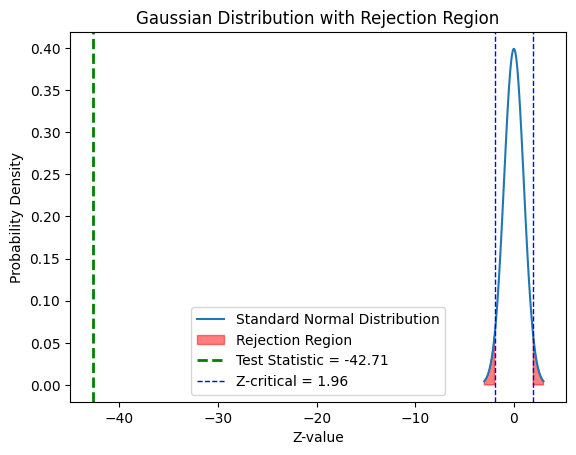

In [45]:
# Parameters for the standard normal distribution
mu = 0  # Mean of standard normal
sigma = 1  # Standard deviation of standard normal
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)  # Z-values range
y = norm.pdf(x, mu, sigma)  # Probability density function values

# Pre-calculated test statistic and critical value
Test_stat = -42.71  # Z-score calculated from A/B test
Z_crit = 1.96       # Z-critical for alpha = 0.05 in two-tailed test

# Plot standard normal curve
plt.plot(x, y, label='Standard Normal Distribution')

# Shade rejection regions (left and right tails)
plt.fill_between(x, y, where=(x > Z_crit) | (x < -Z_crit), color='red', alpha=0.5, label='Rejection Region')

# Add vertical line for test statistic
plt.axvline(Test_stat, color='green', linestyle='dashed', linewidth=2, label=f'Test Statistic = {Test_stat:.2f}')

# Add Z-critical boundaries (±Z_crit)
plt.axvline(Z_crit, color='blue', linestyle='dashed', linewidth=1, label=f'Z-critical = {Z_crit:.2f}')
plt.axvline(-Z_crit, color='blue', linestyle='dashed', linewidth=1)

# Labels and title
plt.xlabel('Z-value')
plt.ylabel('Probability Density')
plt.title('Gaussian Distribution with Rejection Region')
plt.legend()
plt.show()


## Step 10: Practical significance

In [46]:
def is_Practically_significant(delta, CI_95):
    """
    We assess here if the difference between Control and Experimental group 
    is practically significant using the Minimum Detectable Effect (MDE).
    
    Arguments:
    - delta (float): The Minimum Detectable Effect (MDE) considered for practical significance.
    - CI_95 (tuple): A tuple representing the lower and upper bounds of the 95% Confidence Interval.
    
    Returns:
    - Prints whether the experiment has practical significance and returns a boolean value.
    """

    # Extract lower bound of 95% Confidence Interval
    lower_bound_CI = CI_95[0]

    # Check if the lower bound of the CI is greater than or equal to delta
    if lower_bound_CI >= delta:
        print(f"We have practical significance! \nWith MDE of {delta}, the difference between Control and Experimental group is practically significant.")
        return True
    else:
        print(f"We don't have practical significance! \nThe difference between Control and Experimental group is not practically significant.")
        return False


This function helps you test if the observed effect (difference) is practically meaningful.

In [47]:
delta = 0.05  # Minimum effect size we care about
CI_95 = CI    # Reusing previously calculated confidence interval

is_Practically_significant(delta, CI_95)


We have practical significance! 
With MDE of 0.05, the difference between Control and Experimental group is practically significant.


True